<a href="https://colab.research.google.com/github/sdemirus/Relax_Challenge/blob/main/Relax_Challenge_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relax Challenge Solution

This notebook provides my analysis and conclusions to the Relax Data Science Challenge. Here is the narrative that outlines the challenge:

The data is available as two attached CSV files:

takehome_user_engagement. csv

takehome_users . csv

The data has the following two tables:

1 - A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:

* name: the user's name
* object_id: the user's id
* email: email address
* creation_source: how their account was created. This takes on one of 5 values:
  * PERSONAL_PROJECTS: invited to join another user's personal workspace
  * GUEST_INVITE: invited to an organization as a guest (limited permissions)
  * ORG_INVITE: invited to an organization (as a full member)
  * SIGNUP: signed up via the website
  * SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
* creation_time: when they created their account
last_session_creation_time: unix timestamp of last login
* opted_in_to_mailing_list: whether they have opted into receiving marketing emails
* enabled_for_marketing_drip: whether they are on the regular marketing email drip
* org_id: the organization (group of users) they belong to
* invited_by_user_id: which user invited them to join (if applicable).

2 - A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period , identify which factors predict future user adoption.

We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better -- no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

# Solution:
To analyze the data according to the questions in the Relax Data Science Challenge, we need to identify adopted users (those who have logged in at least 3 times within any 7-day period) and determine which factors predict future user adoption.

Steps:

1- Load and Inspect Data:

* Load the takehome_users.csv and takehome_user_engagement.csv files.

* Inspect the structure and contents of both datasets.

2- Define Adopted Users:

* From the takehome_user_engagement.csv, identify users who have logged in on at least 3 separate days within any 7-day window.

* Tag these users as "adopted users."

3- Merge Data:

* Merge the engagement data with the user data (takehome_users.csv), keeping relevant user details (e.g., creation_source, org_id, etc.).

4- Feature Engineering:

* Create new features based on the user data (e.g., account_age, creation_source category encoding, etc.).

* Investigate which features might impact user adoption.

5- Modeling:

* Use a classification algorithm (e.g., Logistic Regression, Random Forest) to predict adoption based on the features.

* Evaluate model performance.

6- Summarize Findings:

* Visualize important features, such as creation_source, account_age, and logins over time.

* Provide a concise report on the findings.

In [126]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [98]:
# Load data
user_data = pd.read_csv('/content/takehome_users.csv', encoding='ISO-8859-1')
engagement_data = pd.read_csv('/content/takehome_user_engagement.csv')

In [99]:
user_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [100]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [101]:
engagement_data.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [102]:
engagement_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [103]:
# Convert 'time_stamp' to datetime format
engagement_data['time_stamp'] = pd.to_datetime(engagement_data['time_stamp'])

In [104]:
# Step 1: Identify adopted users
# Group by user_id and find distinct login dates
engagement_data['login_date'] = engagement_data['time_stamp'].dt.date
user_logins = engagement_data.groupby('user_id')['login_date'].nunique().reset_index()

In [105]:
# Define adopted users: at least 3 distinct login days within a 7-day window
adopted_users = []

for user in engagement_data['user_id'].unique():
    user_login_dates = engagement_data[engagement_data['user_id'] == user]['login_date'].sort_values().unique()
    for i in range(len(user_login_dates) - 2):
        if (user_login_dates[i + 2] - user_login_dates[i]).days <= 7:
            adopted_users.append(user)
            break

In [106]:
# Create a binary column for adoption
user_data['adopted_user'] = user_data['object_id'].apply(lambda x: 1 if x in adopted_users else 0)

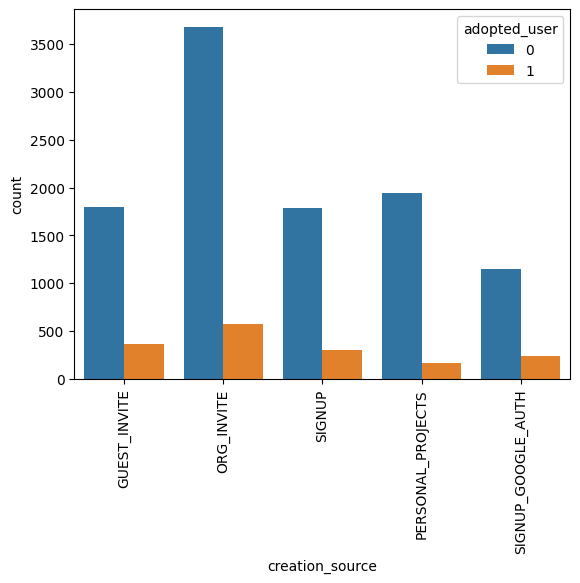

In [121]:
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=user_data, hue='adopted_user')
_ = plt.xticks(rotation=90)

In [107]:
# Step 3: Feature Engineering
# Drop missing values
user_data['invited_by_user_id'].value_counts(ascending=False, dropna=False)
user_data['invited_by_user'] = user_data['invited_by_user_id'].isnull() == False
del user_data['invited_by_user_id']
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   adopted_user                12000 non-null  int64  
 10  invited_by_user             12000 non-null  bool   
dtypes: bool(1), float64(1), int64(5), object(4)
memory usage: 949.3+ KB


In [109]:
# Step 2: Merge user and engagement data
# Dropping unnecessary columns and merging with user_data
merged_data = user_data[['object_id', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',
                         'org_id', 'invited_by_user', 'adopted_user']]
merged_data.columns = ['user_id', 'creation_source', 'opted_in', 'marketing_drip', 'org_id', 'invited_by', 'adopted_user']

In [110]:
# Convert categorical columns to numeric via one-hot encoding
merged_data = pd.get_dummies(merged_data, columns=['creation_source'], drop_first=True)

In [122]:
# Step 4: Build a predictive model

In [124]:
# Define X (features) and y (target)
X = merged_data.drop(columns=['user_id', 'adopted_user'])
y = merged_data['adopted_user']

In [125]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [127]:
# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(X_train, y_train)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 10}
Best average precision was 0.7376190476190476


In [130]:
# Predict and evaluate
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=10
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.7188888888888889
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      3103
           1       0.14      0.21      0.17       497

    accuracy                           0.72      3600
   macro avg       0.50      0.50      0.50      3600
weighted avg       0.76      0.72      0.74      3600



In [132]:
# Step 5: Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

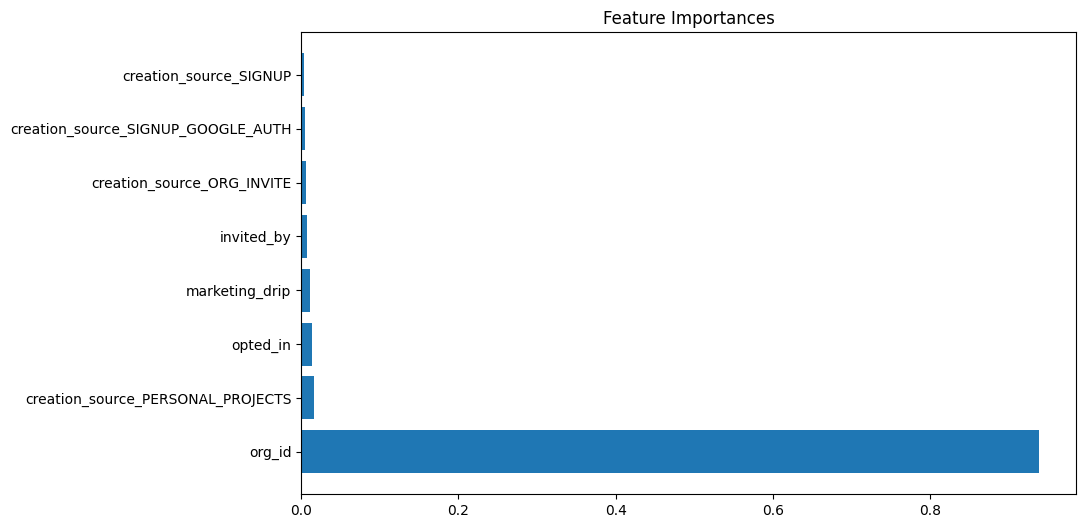

In [133]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), [features[i] for i in indices])
plt.show()

# Summary of Approach:

Data Preparation: Loaded both CSV files and converted timestamps.

Adopted User Definition: Identified users who logged in on 3 different days within a 7-day period.

Feature Engineering: Created binary adoption labels, one-hot encoded categorical features, and prepared the dataset for modeling.

Modeling: Built a Random Forest model to predict adoption based on user features.

Feature Importance: Displayed the importance of various features in predicting user adoption.